# BTC Futures 에 내제되어있는 funding rate term structure 분석

선물 계약은 레버리지가 가능하다. 일정 증거금만 있으면 2배, 3배 많게는 100배 이상 레버리지를 키울 수 있다. 즉 내가 지금 비트코인 10개만큼 사는 포지션을 구축하고 싶은데 레버리지 10배 선물 롱 계약을 체결하면 비트코인 1개로 비트코인 10개만큼 보유하고 있는것과 비슷한 경제적인 효과를 얻을 수 있는 것이다. 투자자가 비트코인 10개를 사려면 비트코인 10개 가치만큼의 현금이 초기에 필요하지만 그만큼의 현금이 없다면 선물이라는 파생상품으로 그 문제를 해결할 수 있는 것이다. 물론 공짜 점심은 없기 때문에 지불해야할 비용이 있는데 바로 Funding Fee 또는 현,선물 basis이다.  \
 일반적인 장내선물 파생상품은 대부분 만기가 정해져 있다. 코인선물시장에서는 만기가 정해진 파생상품도 존재하지만, 거래량과 open interest 가 압도적으로 많은 파생상품은 perpetual 선물이다. BTC perpetual 선물은 만기가 없고 8시간마다(일반적으로) Funding Fee 만큼 정산을 하게 되는데 이걸 1년동안 누적하면 연율화 된 비용이 나오게 된다. 즉 펀딩피를 1년동안 모두 더하면 선물 롱 계약 매수자가 레버리지 1배를 증가시킬 때 마다 드는 비용이 나올 것이다.  \ 
 해외 코인 거래소에서 물론 만기가 있는 선물도 존재한다. 만기가 있는 선물은 가격에 내제되어있는 금리를 구할 수 있고 만기가 길게는 1년까지 존재한다.

 만기가 없는 선물, 만기가 있는 선물의 내제되어있는 금리를 분석하여 선물간 spread 거래를 하거나, 통계적으로 금리가 회귀하는 성질을 이용하여 통계적 차익거래 전략을 생각해 볼 수 있을 것이다.  \

코인 관련 파생상품은 deribit 거래소가 다양한 파생거래를 지원해 주기 때문에 해당 거래소 내에서만 분석을 먼저 해보자.(옵션상품 역시 다양한 행사가별, 만기별 상품이 존재)

In [1]:
from crypto import pyderibit, CONFIG
api = pyderibit.Deribit(CONFIG.DERIBIT['MAIN_URL'])

In [2]:
dict_fut = api.get_instruments_all_list('BTC','2018-01-01')

In [5]:
import datetime
currency = 'BTC'
end_time = datetime.datetime.now()
start_time = end_time - datetime.timedelta(days=3000)
df_all_data = api.get_historical_futures_price(currency+'-'+'PERPETUAL', start_time, end_time)[['ticks','close']]

In [7]:
import pandas as pd
for symbol, item in ls_fut.items():
    df_k_price = api.get_historical_futures_price(symbol, start_time, end_time)
    df_k_price = df_k_price[((df_k_price.ticks >= item['creation_timestamp']) & (df_k_price.ticks <item['expiration_timestamp']))]
    df_k_price = df_k_price[['ticks','close']]
    df_all_data = pd.merge(df_all_data,df_k_price,on = 'ticks', how='left', suffixes = ('','_'+symbol))
    print(df_k_price)

df_all_data['datetime'] = pd.to_datetime(df_all_data['ticks'], unit='ms')
df_all_data.set_index('datetime', inplace=True)

df_all_data.columns = [col.replace('close_', '') for col in df_all_data.columns]
df_all_data = df_all_data.drop(columns=['ticks','close'])
df_all_data = df_all_data.dropna(subset=[currency+'-PERPETUAL'])

                             ticks     close
timestamp                                   
2017-12-28 08:00:00  1514448000000  15069.46
2017-12-29 08:00:00  1514534400000  13564.52
2017-12-30 08:00:00  1514620800000  12979.04
2017-12-31 08:00:00  1514707200000  13875.18
2018-01-01 08:00:00  1514793600000  13624.18
2018-01-02 08:00:00  1514880000000  15608.15
2018-01-03 08:00:00  1514966400000  15167.24
2018-01-04 08:00:00  1515052800000  15229.50
2018-01-05 08:00:00  1515139200000  16643.21
2018-01-06 08:00:00  1515225600000  17304.88
2018-01-07 08:00:00  1515312000000  16349.37
2018-01-08 08:00:00  1515398400000  15359.99
2018-01-09 08:00:00  1515484800000  14379.09
2018-01-10 08:00:00  1515571200000  13800.43
2018-01-11 08:00:00  1515657600000  13750.71
2018-01-12 08:00:00  1515744000000  14647.19
2018-01-13 08:00:00  1515830400000  13981.49
2018-01-14 08:00:00  1515916800000  13707.54
2018-01-15 08:00:00  1516003200000  12437.44
2018-01-16 08:00:00  1516089600000  11160.82
2018-01-17

In [10]:
from models import termstruc
model = termstruc.InterestTermStructure('BTC', df_all_data, dict_fut)

In [11]:
ls = {}
ls_mty = []
term = [30, 60, 120, 180, 240, 300, 360]
for i in df_all_data.index[2000:]:
    ls_term = []
    for j in term:
        ls_term.append(model.get_zrate(i, i + datetime.timedelta(days = j)))
    ls[i] = ls_term
    ls_mty.append(ls_term)

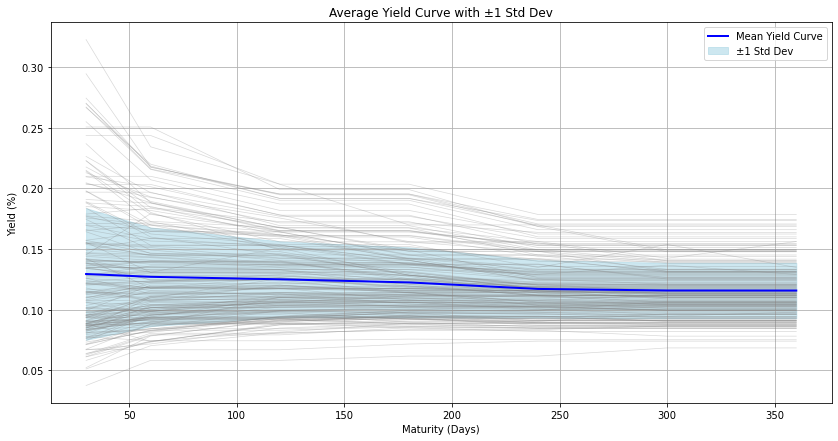

In [24]:
import matplotlib.pyplot as plt

df_data = pd.DataFrame(ls_mty)

mean_yield = df_data.mean(axis=0)
std_yield = df_data.std(axis=0) * 1

# 그래프 그리기
plt.figure(figsize=(14, 7))

sampled_dates = df_data.index

for date in sampled_dates:
    plt.plot(term, df_data.loc[date], alpha=0.3, color = 'gray', linewidth=0.7)

plt.plot(term, mean_yield, color='blue', linewidth=2, label='Mean Yield Curve')
plt.fill_between(term, mean_yield - std_yield, mean_yield + std_yield, color='lightblue', alpha=0.6, label='±1 Std Dev')

plt.title('Average Yield Curve with ±1 Std Dev')
plt.xlabel('Maturity (Days)')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


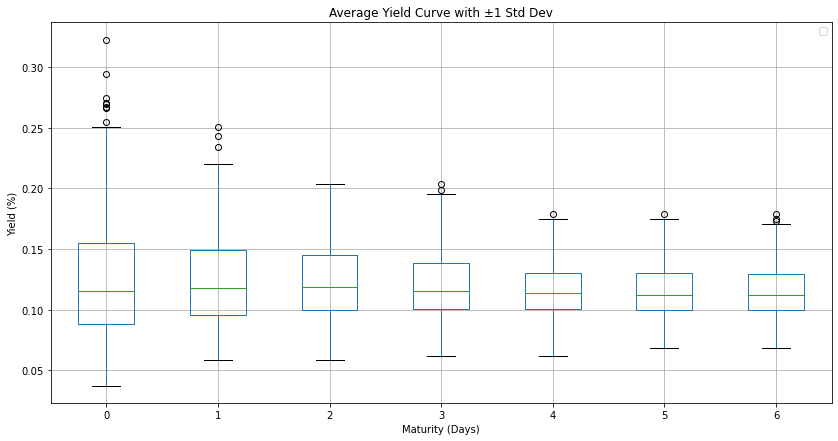

In [29]:
plt.figure(figsize=(14, 7))
df_data.boxplot()

plt.title('Average Yield Curve with ±1 Std Dev')
plt.xlabel('Maturity (Days)')
plt.ylabel('Yield (%)')
plt.grid(True)
plt.legend()
plt.show()